# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
def entropy(p_arr):
  p_arr *= np.log(p_arr)
  return -np.sum(p_arr)

print(np.round(entropy([8/10, 2/10]), 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
def H(p_arr):
  p_arr *= -1 * (p_arr - 1)
  return np.sum(p_arr)

print(np.round(H(np.array([0.8, 0.2])) - 0.2 * H(np.array([1, 0])) - 0.8 * H(np.array([1, 0])), 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
lst = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

sum(lst)/len(lst)

40.6

Для всех предсказание будет одинаковым, тк в одном листе они

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    pass

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    thresholds = []
    ginis = []
    gini_best = 10**6
    threshold_best = -1
    if feature_type == 'real':
      tr = np.sort(feature_vector)
      thresholds = np.unique((tr[:-1] + tr[1:]) * 0.5)
    else:
      thresholds = set(feature_vector)
    if task == 'classification':
      n = {}
      N = len(feature_vector)
      left_сlasess = {}
      left_ids = []
      t0 = thresholds[0]
      for i in range(N):
          n[target_vector[i]] = n.get(target_vector[i], 0) + 1
          if feature_vector[i] != t0:
              left_сlasess[target_vector[i]] = left_сlasess.get(target_vector[i], 0) + 1
              left_ids.append(i)
      p_all = np.array([n[key] for key in n.keys()])
      p_left = np.array([len(left_сlasess.get(key, 0)) for key in n.keys()])
      p_right = np.array([p_all[j]-p_left[j] for j in range(len(n))])
      gini = H(p_all/N) - (len(left_сlasess)/N) * H(p_left/len(left_сlasess)) -  ((N - len(left_сlasess))/N) * H(p_right/(N - len(left_сlasess)))
      ginis.append(gini)
      if gini < gini_best:
        gini_best = gini
        threshold_best = t0
      for ti in range(1, len(thresholds)):
        t = thresholds[ti]
        lc = []
        for i in left_ids:
          if feature_vector[i] != t:
            lc.append(t)
          else:
            left_сlasess[target_vector[i]] -= 1
        left_ids = lc
        p_left = np.array([len(left_сlasess.get(key, 0)) for key in n.keys()])
        p_right = np.array([p_all[j]-p_left[j] for j in range(len(n))])
        gini = H(p_all/N) - (len(left_сlasess)/N) * H(p_left/len(left_сlasess)) -  ((N - len(left_сlasess))/N) * H(p_right/(N - len(left_сlasess)))
        ginis.append(gini)
        if gini < gini_best:
          gini_best = gini
          threshold_best = t
    else:

      N = len(feature_vector)
      left_ids = []
      sm_all = 0
      sm2_all = 0
      sm_left = 0
      sm2_left = 0
      sm2_right = 0
      t0 = thresholds[0]
      for i in range(N):
        sm_all += target_vector[i]
        sm2_all += target_vector[i] ** 2
        if feature_vector[i] > t0:
          sm_left += target_vector[i]
          sm2_left += target_vector[i] ** 2
          left_ids.append(i)
        else:
          sm2_right += target_vector[i] ** 2
      Dall = (sm2_all-(sm_all ** 2 / N))/(N-1)
      Dleft = (sm2_left-(sm_left ** 2 / len(left_ids)))/(len(left_ids)-1)
      Dright = (sm2_right-(sm_all - sm_left) ** 2 / (N - len(left_ids)))/(N - len(left_ids)-1)
      gini = Dall - Dleft * (len(left_ids)/N) - Dright * ((N-len(left_ids))/N)
      print(gini)
      ginis.append(gini)
      if gini < gini_best:
        gini_best = gini
        threshold_best = t0
      for ti in range(1, len(thresholds)):
        t = thresholds[ti]
        lc = []
        for i in left_ids:
          if feature_vector[i] > t:
            lc.append(i)
          else:
            sm2_right += target_vector[i] ** 2
            sm2_left -= target_vector[i] ** 2
            sm_left -= target_vector[i]
        left_ids = lc
        Dleft = (sm2_left-(sm_left ** 2 / len(left_ids)))/(len(left_ids)-1)
        Dright = (sm2_right-(sm_all - sm_left) ** 2 / (N - len(left_ids)))/(N - len(left_ids)-1)
        gini = Dall - Dleft * (len(left_ids)/N) - Dright * ((N-len(left_ids))/N)
        ginis.append(gini)

        if gini < gini_best:
          gini_best = gini
          threshold_best = t
    return np.array(thresholds), np.array(ginis), threshold_best, gini_best



Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
thresholds, ginis, threshold_best, gini_best = find_best_split(X['MedInc'], y, 'regression', 'real')

-1.689773680521242e-05


<ipython-input-13-60488105a383>:90: RuntimeWarning: divide by zero encountered in scalar divide
  Dleft = (sm2_left-(sm_left ** 2 / len(left_ids)))/(len(left_ids)-1)
<ipython-input-13-60488105a383>:92: RuntimeWarning: invalid value encountered in scalar multiply
  gini = Dall - Dleft * (len(left_ids)/N) - Dright * ((N-len(left_ids))/N)


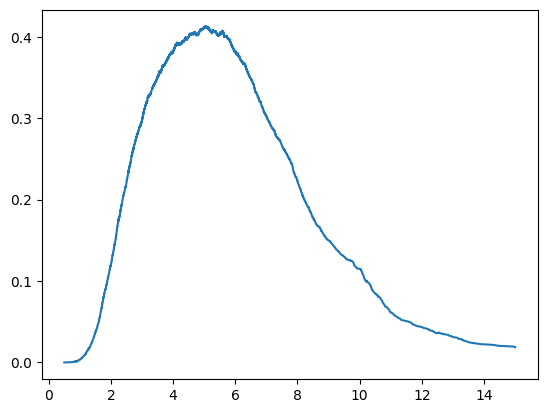

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, ginis)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

**Задание 2.4 (1 балл)** Протестируйте решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [74]:
from sklearn.preprocessing import LabelEncoder

In [86]:
data = pd.read_csv('agaricus-lepiota.data')

for cl in data.columns:
  le = LabelEncoder()
  le.fit(data[cl])
  data[cl] = le.transform(data[cl])


Да, я понимаю, что я взял готовое дерево. Взял в надежде, что по сути решения
 2.4 это не меняет

In [91]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data.drop('p', axis=1)
Y = data['p']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
dt = DecisionTreeRegressor()
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)
print("Accuracy", accuracy_score(Y_pred, Y_test))

Accuracy 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [11]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [4]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

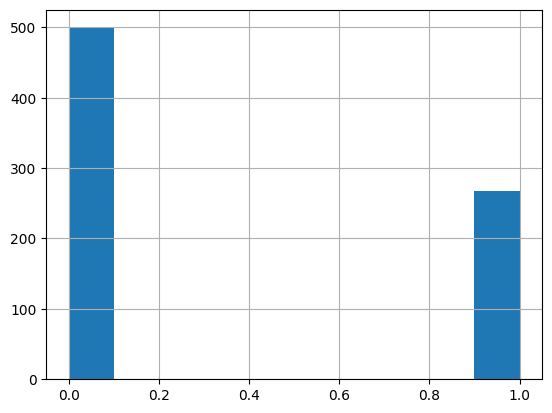

In [5]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [39]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)
Y = data['Outcome']
trainFUL_X, test_X, trainFUL_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
train_X, valid_X,  train_Y, valid_Y = train_test_split(trainFUL_X, trainFUL_Y, test_size=0.3, random_state=0)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [40]:

max_depth_sp = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30]
min_samples_leaf_sp = [200, 100, 80, 60, 40, 20, 10, 5]
f1_best = 0
md_best = 0
msl_best = 0
for md in max_depth_sp:
  for msl in min_samples_leaf_sp:
    c
    f1 = f1_score(valid_Y, Y_pred)
    if f1 >= f1_best:
      f1_best = f1
      md_best = md
      msl_best = msl


print(f1_best, md_best, msl_best)

0.6370370370370371 30 80


In [41]:
dt = DecisionTreeClassifier(max_depth=md_best, min_samples_leaf=msl_best)
dt.fit(trainFUL_X, trainFUL_Y)
Y_pred = dt.predict(test_X)
print("Accuracy", accuracy_score(Y_pred, test_Y))
print("Precision", precision_score(Y_pred, test_Y))
print("Recall", recall_score(Y_pred, test_Y))
print("ROC_AUC", roc_auc_score(Y_pred, test_Y))

Accuracy 0.7316017316017316
Precision 0.6666666666666666
Recall 0.6067415730337079
ROC_AUC 0.7083003639816428


Все 60+, 70+. А значит все неплохо

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [43]:

bag = BaggingClassifier(dt, n_estimators=50)
bag.fit(trainFUL_X, trainFUL_Y)
Y_pred = bag.predict(test_X)
print("Accuracy", accuracy_score(Y_pred, test_Y))
print("Precision", precision_score(Y_pred, test_Y))
print("Recall", recall_score(Y_pred, test_Y))
print("ROC_AUC", roc_auc_score(Y_pred, test_Y))

Accuracy 0.7619047619047619
Precision 0.6296296296296297
Recall 0.6710526315789473
ROC_AUC 0.7387521222410866


Качество улучшилось от 3 до 7 % за исключением Precision

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [44]:
max_depth_sp = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30]
min_samples_leaf_sp = [200, 100, 80, 60, 40, 20, 10, 5]
f1_best = 0
md_best = 0
msl_best = 0
for md in max_depth_sp:
  for msl in min_samples_leaf_sp:
    f1_sp = []
    for rs in [0, 13, 101, 117, 211, 666]:
      train_X, valid_X,  train_Y, valid_Y = train_test_split(trainFUL_X, trainFUL_Y, test_size=0.3, random_state=rs)
      dt = DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl)
      bag = BaggingClassifier(dt, n_estimators=50)
      bag.fit(train_X, train_Y)
      Y_pred = bag.predict(valid_X)
      f1_sp.append(f1_score(valid_Y, Y_pred))
    f1 = sum(f1_sp)/len(f1_sp)
    if f1 >= f1_best:
      f1_best = f1
      md_best = md
      msl_best = msl


print(f1_best, md_best, msl_best)

0.6026405182859655 7 10


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [53]:
n_sp = [1, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300]
ar_sp = []
for n in n_sp:
  dt = DecisionTreeClassifier(max_depth=md_best, min_samples_leaf=msl_best)
  bag = BaggingClassifier(dt, n_estimators=n)
  bag.fit(trainFUL_X, trainFUL_Y)
  Y_pred = bag.predict(valid_X)
  ar_sp.append(roc_auc_score(Y_pred, valid_Y))

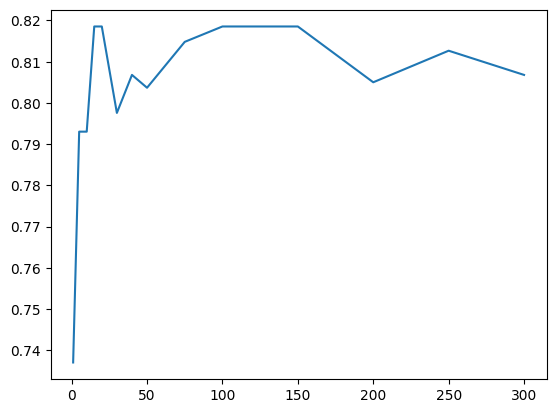

In [54]:
import matplotlib.pyplot as plt

plt.plot(n_sp, ar_sp)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [72]:
dt = DecisionTreeClassifier(max_depth=md_best, min_samples_leaf=msl_best)
dt.fit(trainFUL_X, trainFUL_Y)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10)

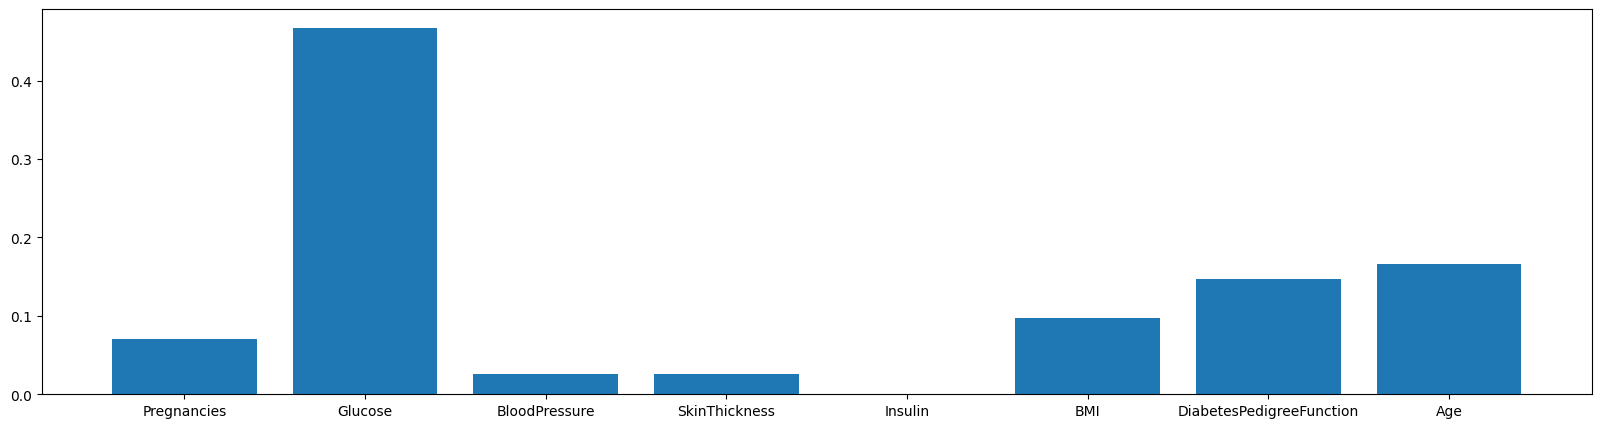

In [73]:
names = list(trainFUL_X.columns)
plt.figure(figsize=(20, 5))
plt.bar(names, dt.feature_importances_);

Глюкоза